# Approach 3: Multi-Armed Bandits

We will use bandits for movie recommendation. 

## Data
For data exploration, please refer to the notebook eda.ipynb, where common techniques for feature engineering are also discussed. <br>
We will use the entire dataset (u.data), but focus on movies with significant user feedback, by selecting movies with greater than 200 ratings. <br> <br>
We will also divide the dataset into four groups based on:
- Male, Young (age < 30)
- Male, Adult (age ≥ 30)
- Female, Young (age < 30)
- Female, Adult (age ≥ 30)


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
movies = pd.read_csv('data/u.item', sep='|', header=None, encoding='latin1', index_col=False,
                     names=['movie_id',
                            'movie_title',
                            'release_date',
                            'video_release_date',
                            'imdb_url',
                            'unknown',
                            'action',
                            'adventure',
                            'animation',
                            'children',
                            'comedy',
                            'crime',
                            'documentary',
                            'drama',
                            'fantasy',
                            'film_noir',
                            'horror',
                            'musical',
                            'mystery',
                            'romance',
                            'sci_fi',
                            'thriller',
                            'war',
                            'western'])

ratings = pd.read_csv('data/u.data', sep='\t', header=None, names=['user_id','movie_id','rating','timestamp'])

print(f'movies shape: {movies.shape}')
print(f'ratings shape: {ratings.shape}')

movies shape: (1682, 24)
ratings shape: (100000, 4)


## Visualization and Feature Engineering

Let's look at the shapes of the movies and ratings dataset

In [3]:
movies.head()

,movie_id,movie_title,release_date,video_release_date,imdb_url,unknown,action,adventure,animation,children,...,fantasy,film_noir,horror,musical,mystery,romance,sci_fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Movies with top number of ratings

Look at the movies with the most number of ratings, and select movies with > 200 ratings

In [5]:
# select movies with > 200 ratings
movie_ratings_count = ratings.groupby('movie_id')['rating'].count()
popular_movies = movie_ratings_count[movie_ratings_count > 200]

# merge for movie title
popular_movies = pd.merge(
    popular_movies.reset_index(), 
    movies[['movie_id', 'movie_title']], 
    on='movie_id'
)

popular_movies = popular_movies.sort_values('rating', ascending=False)
print(f"Number of movies with >200 ratings: {len(popular_movies)}")
print("\nTop movies by number of ratings:")
popular_movies.head(10)

Number of movies with >200 ratings: 117

Top movies by number of ratings:


,movie_id,rating,movie_title
11,50,583,Star Wars (1977)
73,258,509,Contact (1997)
25,100,508,Fargo (1996)
47,181,507,Return of the Jedi (1983)
85,294,485,Liar Liar (1997)
82,286,481,"English Patient, The (1996)"
83,288,478,Scream (1996)
0,1,452,Toy Story (1995)
86,300,431,Air Force One (1997)
29,121,429,Independence Day (ID4) (1996)


In [6]:
# filter out ratings for these movies
popular_movie_ids = popular_movies['movie_id']

# filter the ratings DataFrame to include only ratings for these movies
print(f"Number of ratings before filtering: {len(ratings)} for {ratings['movie_id'].nunique()} movies")
ratings = ratings[ratings['movie_id'].isin(popular_movie_ids)]
print(f"Number of ratings after filtering: {len(ratings)} for {ratings['movie_id'].nunique()} movies")
ratings.head()

Number of ratings before filtering: 100000 for 1682 movies
Number of ratings after filtering: 33480 for 117 movies


,user_id,movie_id,rating,timestamp
1,186,302,3,891717742
6,115,265,2,881171488
10,62,257,2,879372434
12,200,222,5,876042340
22,299,144,4,877881320


### Drop timestamp, likely irrelevant

In [7]:
ratings = ratings.drop('timestamp', axis=1)

### Add movie titles
Also clean up movie titles by removing the year

In [8]:
ratings = pd.merge(ratings, movies[['movie_id', 'movie_title']], on='movie_id')
ratings['movie_title'] = ratings['movie_title'].str.extract(r'^(.*?)\s*\(\d+\)$')
ratings.sort_values(by='movie_id')

,user_id,movie_id,rating,movie_title
1728,308,1,4,Toy Story
2038,893,1,5,Toy Story
2037,336,1,3,Toy Story
2036,303,1,5,Toy Story
2035,886,1,4,Toy Story
...,...,...,...,...
15759,356,748,4,"Saint, The"
15760,294,748,3,"Saint, The"
15761,190,748,3,"Saint, The"
15752,127,748,5,"Saint, The"


### Transform discrete rating into binary variable (like/dislike)

In [9]:
ratings['liked'] = ratings['rating'].apply(lambda x: True if x in [4, 5] else False)
ratings.head()

,user_id,movie_id,rating,movie_title,liked
0,186,302,3,L.A. Confidential,False
1,191,302,4,L.A. Confidential,True
2,49,302,4,L.A. Confidential,True
3,54,302,4,L.A. Confidential,True
4,62,302,3,L.A. Confidential,False


Visualize like rating distribution for movies

In [10]:
# count number of likes and total ratings
liked_ratings_count = ratings[ratings['liked'] == True].groupby('movie_title')['liked'].count().reset_index()
total_ratings_count = ratings.groupby('movie_title')['liked'].count().reset_index()

# calculate % of likes
merged_df = liked_ratings_count.merge(total_ratings_count, on='movie_title', suffixes=('_count', '_total'))
merged_df['like_percentage'] = (merged_df['liked_count'] / merged_df['liked_total']) * 100

sorted_df = merged_df.sort_values(by='like_percentage', ascending=False)
sorted_df

,movie_title,liked_count,liked_total,like_percentage
88,"Shawshank Redemption, The",255,283,90.106007
84,Schindler's List,265,298,88.926174
20,Casablanca,216,243,88.888889
80,Rear Window,185,209,88.516746
90,"Silence of the Lambs, The",344,390,88.205128
...,...,...,...,...
30,"Devil's Own, The",84,240,35.000000
70,Murder at 1600,75,218,34.403670
27,Dante's Peak,74,240,30.833333
65,Mars Attacks!,59,217,27.188940


### Divide the dataset into 4 different groups

Load user information and analyse each of these different groups by the most liked movies. This will be the optimal scenario for the MAB algorithm, where in each of the group, these top movies recommended will give the highest rewards.

In [11]:
# load user info
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_df = pd.read_csv('data/u.user', sep='|', names=user_columns)

In [12]:
merged_df = pd.merge(ratings, users_df, on='user_id')

# categorise into young/adult groups
merged_df['age_group'] = np.where(merged_df['age'] < 30, 'Young', 'Adult')

# divide into four demographic groups
demographic_groups = {
    'Male_Young': (merged_df['gender'] == 'M') & (merged_df['age_group'] == 'Young'),
    'Male_Adult': (merged_df['gender'] == 'M') & (merged_df['age_group'] == 'Adult'),
    'Female_Young': (merged_df['gender'] == 'F') & (merged_df['age_group'] == 'Young'),
    'Female_Adult': (merged_df['gender'] == 'F') & (merged_df['age_group'] == 'Adult')
}

for group_name, group_filter in demographic_groups.items():
    group_data = merged_df[group_filter]
    
    print(f"\n{group_name.replace('_', ' ')}:")
    print(f"Number of users: {len(group_data['user_id'].unique()):,}")
    print(f"Number of ratings: {len(group_data):,}")
    print(f"Like ratio: {(group_data['liked'] == 1).mean():.1%}")
    
    print("\nTop 5 movies:")
    top_movies = (group_data.groupby('movie_title')['liked']
                 .agg(['mean', 'count'])
                 .sort_values(['mean', 'count'], ascending=[False, False])
                 .head())
    print(top_movies)
    print("\n" + "="*50)


Male Young:
Number of users: 292
Number of ratings: 11,838
Like ratio: 67.6%

Top 5 movies:
                               mean  count
movie_title                               
Silence of the Lambs, The  0.928000    125
Godfather, The             0.911290    124
Shawshank Redemption, The  0.909910    111
Casablanca                 0.909091     66
Empire Strikes Back, The   0.901408    142


Male Adult:
Number of users: 378
Number of ratings: 13,250
Like ratio: 66.2%

Top 5 movies:
                                     mean  count
movie_title                                     
Rear Window                      0.909091     99
To Kill a Mockingbird            0.896552     87
Schindler's List                 0.896000    125
One Flew Over the Cuckoo's Nest  0.894309    123
Shawshank Redemption, The        0.888889    108


Female Young:
Number of users: 117
Number of ratings: 3,935
Like ratio: 65.4%

Top 5 movies:
                               mean  count
movie_title                    

## Epsilon-Greedy Multi-Armed Bandit algorithm

We will be adapting and improving the code provided in tutorial. The improvements made will be to increase efficiency of training and running the simulation.

In [13]:
class ReplaySimulator(object):
    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1, random_seed=1):
        np.random.seed(random_seed)
        
        # store input data and parameters
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name
        self.n_visits = n_visits
        self.n_iterations = n_iterations
        
        # Pre-compute unique items and visitors
        self.items = reward_history[item_col_name].unique()
        self.n_items = len(self.items)
        self.visitors = reward_history[visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        # Create a lookup dictionary for faster reward retrieval
        self._create_interaction_lookup()
        
    def _create_interaction_lookup(self):
        """Create a dictionary for fast reward lookups"""
        self.interaction_lookup = {}
        for item_id in self.items:
            item_data = {}
            item_interactions = self.reward_history[self.reward_history[self.item_col_name] == item_id]
            for _, row in item_interactions.iterrows():
                item_data[row[self.visitor_col_name]] = row[self.reward_col_name]
            self.interaction_lookup[item_id] = item_data
    
    def reset(self):
        self.n_item_samples = np.zeros(self.n_items)
        self.n_item_rewards = np.zeros(self.n_items)
    
    def replay(self):
        # Pre-allocate results list with known size
        total_results = self.n_iterations * self.n_visits
        results = [None] * total_results
        result_idx = 0
        
        for iteration in tqdm(range(self.n_iterations)):
            self.reset()
            total_rewards = 0
            
            for visit in range(self.n_visits):
                # keep iterating until we find a valid interaction that is in the dataset
                while True:
                    visitor_id = self.visitors[np.random.randint(self.n_visitors)]
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # fast lookup using dictionary instead
                    reward_value = self.interaction_lookup[item_id].get(visitor_id)
                    if reward_value is not None:
                        break
                
                self.record_result(visit, item_idx, reward_value)
                
                # update the associated metrics
                total_rewards += reward_value
                fraction_relevant = total_rewards / (visit + 1)
                
                # store result using pre-allocated space
                results[result_idx] = {
                    'iteration': iteration,
                    'visit': visit,
                    'item_id': item_id,
                    'visitor_id': visitor_id,
                    'reward': reward_value,
                    'total_reward': total_rewards,
                    'fraction_relevant': fraction_relevant
                }
                result_idx += 1
        
        return results
    
    def select_item(self):
        return np.random.randint(self.n_items)
    
    def record_result(self, visit, item_idx, reward):
        self.n_item_samples[item_idx] += 1
        alpha = 1. / self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])

Simple Epsilon Greedy Simulator adapted from tutorial code

In [14]:
class EpsilonGreedySimulator(ReplaySimulator):
    def __init__(self, epsilon, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.epsilon = epsilon

    def select_item(self):
        if np.random.random() < self.epsilon:
            # exploration: select random item
            return np.random.randint(self.n_items)
        else:
            # Exploitation: select item with highest reward
            return np.argmax(self.n_item_rewards)

Functions to get the true top movies for evaluation

In [15]:
def get_true_top_movies(group_data, n=5):
    movie_stats = (group_data.groupby('movie_title')
                  .agg({
                      'liked': ['count', 'mean']
                  }).droplevel(0, axis=1))
    
    top_movies = (movie_stats.sort_values(['mean', 'count'], ascending=[False, False]).head(n)) # sort by ratio of likes then count
    return top_movies


Functions to plot the results

In [16]:
def plot_performance_comparison(group_name, results_by_epsilon):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = ['b', 'g', 'r', 'c', 'm']
    styles = ['-', '--', ':', '-.', '-']
    
    for (epsilon, results), color, style in zip(results_by_epsilon.items(), colors, styles):
        ax.plot(results['avg_results'].visit, 
                results['avg_results'].fraction_relevant, 
                f'{color}{style}', 
                linewidth=1.5,
                label=f'ε = {epsilon}')
    
    ax.set_title(f'Percentage of Liked Recommendations - {group_name}')
    ax.set_xlabel('Recommendation #')
    ax.set_ylabel('% of Recs Liked')
    ax.set_yticklabels((ax.get_yticks()*100).astype(int))
    
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

def plot_movie_distribution(group_name, best_epsilon_results, top_n=10):
    # cumulative recommendations orf each movie
    results_df = best_epsilon_results['results_df']
    
    # running totals for each movie
    movie_counts = pd.crosstab(results_df['visit'], 
                              results_df['item_id'], 
                              normalize='index') * 100
    
    # top N most recommended movies
    top_movies = movie_counts.sum().nlargest(top_n).index
    movie_counts = movie_counts[top_movies]
    
    # Create the stacked area plot
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_movies)))
    ax.stackplot(movie_counts.index,
                 movie_counts.values.T,
                 labels=top_movies,
                 colors=colors)
    
    ax.set_xlim(0, n_visits)
    ax.set_xticks(range(0, n_visits + 1, n_visits // 4))
    
    ax.set_title(f'Movie Distribution in Recommendations (ε = {best_epsilon}) - {group_name}')
    ax.set_xlabel('Recommendation #')
    ax.set_ylabel('% of Recommendations')
    
    lgd = plt.legend(bbox_to_anchor=(1.02, 0.15), 
                     loc=2, 
                     borderaxespad=0., 
                     labelspacing=-2.3)
    
    ax.set_facecolor('w')
    plt.tight_layout()
    plt.show()

### Run Simulation for each Group

In [17]:
def analyze_and_plot_group(group_name, group_data, epsilon_values, n_visits, n_iterations):
    print(f"\n{'='*50}\nAnalyzing {group_name}\n{'='*50}")
    
    # Get true top 5 movies for this group
    true_top_movies = get_true_top_movies(group_data)
    print("\nTrue Top 5 Most-Liked Movies:")
    for idx, (movie, stats) in enumerate(true_top_movies.iterrows(), 1):
        print(f"{idx}. {movie:<50} (Like ratio: {stats['mean']:.1%}, Count: {stats['count']})")
    
    # Run simulations for all epsilon values
    results_by_epsilon = {}
    best_overlap = 0
    best_epsilon = None
    best_recommendations = None
    
    print("\nTesting different epsilon values...")
    for epsilon in epsilon_values:
        simulator = EpsilonGreedySimulator(
            epsilon=epsilon,
            n_visits=n_visits,
            reward_history=group_data,
            item_col_name='movie_title',
            visitor_col_name='user_id',
            reward_col_name='liked',
            n_iterations=n_iterations
        )
        
        simulation_results = simulator.replay()
        results_df = pd.DataFrame(simulation_results)
        
        # Get top 5 recommended movies
        movie_performance = pd.DataFrame({
            'movie': simulator.items,
            'reward': simulator.n_item_rewards,
            'samples': simulator.n_item_samples
        }).sort_values('reward', ascending=False)
        
        top_5_recommended = movie_performance.head()
        
        # Calculate overlap
        overlap = len(set(top_5_recommended['movie']) & set(true_top_movies.index))
        overlap_percentage = (overlap / 5) * 100
        
        results_by_epsilon[epsilon] = {
            'simulator': simulator,
            'results_df': results_df,
            'overlap': overlap_percentage,
            'recommendations': top_5_recommended
        }
        
        if overlap_percentage > best_overlap:
            best_overlap = overlap_percentage
            best_epsilon = epsilon
            best_recommendations = top_5_recommended
    
    # print results for best epsilon only
    print(f"\nBest Configuration:")
    print(f"Epsilon: {best_epsilon}")
    print(f"Overlap with true top 5: {best_overlap:.1f}%")
    print("\nRecommended Top 5 Movies:")
    for idx, row in best_recommendations.iterrows():
        movie = row['movie']
        likes_ratio = (group_data[group_data['movie_title'] == movie]['liked'] == 1).mean()
        print(f"{idx+1}. {movie:<50} (Predicted reward: {row['reward']:.3f}, "
              f"Actual like ratio: {likes_ratio:.1%})")
    
    # plot performance comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(epsilon_values)))
    
    for (epsilon, results), color in zip(results_by_epsilon.items(), colors):
        avg_results = results['results_df'].groupby('visit')['fraction_relevant'].mean()
        ax.plot(avg_results.index, 
                avg_results.values, 
                color=color,
                linewidth=1.5,
                label=f'ε = {epsilon}')
    
    ax.set_title(f'Percentage of Liked Recommendations - {group_name}')
    ax.set_xlabel('Recommendation #')
    ax.set_ylabel('% of Recs Liked')
    ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    # plot movie distribution for best epsilon
    best_results = results_by_epsilon[best_epsilon]['results_df']
    movie_counts = pd.crosstab(best_results['visit'], 
                              best_results['item_id'], 
                              normalize='index')
    
    # visualize the top 10 most recommended movies
    top_movies = movie_counts.sum().nlargest(10)
    movie_counts = movie_counts[top_movies.index]
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.stackplot(movie_counts.index,
                 movie_counts.values.T,
                 labels=top_movies.index,
                 colors=plt.cm.viridis(np.linspace(0, 1, len(top_movies))))
    
    ax.set_title(f'Movie Distribution in Recommendations (ε = {best_epsilon}) - {group_name}')
    ax.set_xlabel('Recommendation #')
    ax.set_ylabel('% of Recommendations')
    ax.set_xlim(0, n_visits)
    ax.set_xticks(range(0, n_visits + 1, n_visits // 4))
    
    lgd = plt.legend(bbox_to_anchor=(1.02, 0.15), 
                     loc=2, 
                     borderaxespad=0., 
                     labelspacing=-2.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'best_epsilon': best_epsilon,
        'best_overlap': best_overlap,
        'true_top_5': true_top_movies,
        'recommended_top_5': best_recommendations
    }

In [62]:
# initialize parameters
n_visits = 20000
n_iterations = 20
epsilon_values = [00.02, 0.04, 0.06, 0.08, 0.10, 0.2, 0.3, 0.4, 0.5]
results = {}

=== Epsilon-Greedy MAB Analysis by Demographic Group ===


Analyzing Male_Young

True Top 5 Most-Liked Movies:
1. Silence of the Lambs, The                          (Like ratio: 92.8%, Count: 125.0)
2. Godfather, The                                     (Like ratio: 91.1%, Count: 124.0)
3. Shawshank Redemption, The                          (Like ratio: 91.0%, Count: 111.0)
4. Casablanca                                         (Like ratio: 90.9%, Count: 66.0)
5. Empire Strikes Back, The                           (Like ratio: 90.1%, Count: 142.0)

Testing different epsilon values...


100%|██████████| 20/20 [00:05<00:00,  3.36it/s]



Best Configuration:
Epsilon: 0.2
Overlap with true top 5: 80.0%

Recommended Top 5 Movies:
57. Casablanca                                         (Predicted reward: 0.910, Actual like ratio: 90.9%)
21. Godfather, The                                     (Predicted reward: 0.908, Actual like ratio: 91.1%)
35. Silence of the Lambs, The                          (Predicted reward: 0.906, Actual like ratio: 92.8%)
26. Star Wars                                          (Predicted reward: 0.903, Actual like ratio: 89.1%)
55. Empire Strikes Back, The                           (Predicted reward: 0.900, Actual like ratio: 90.1%)


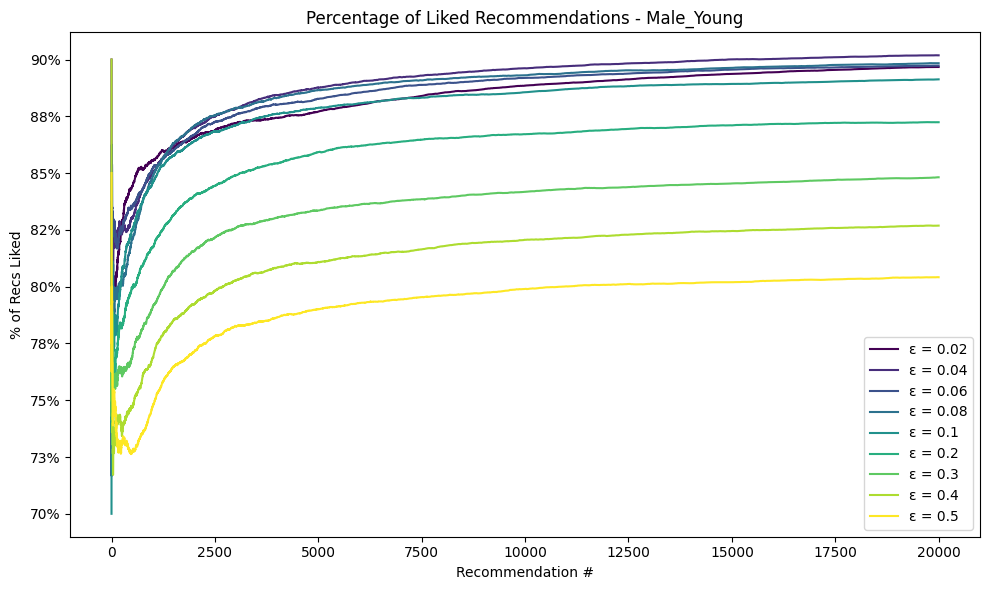

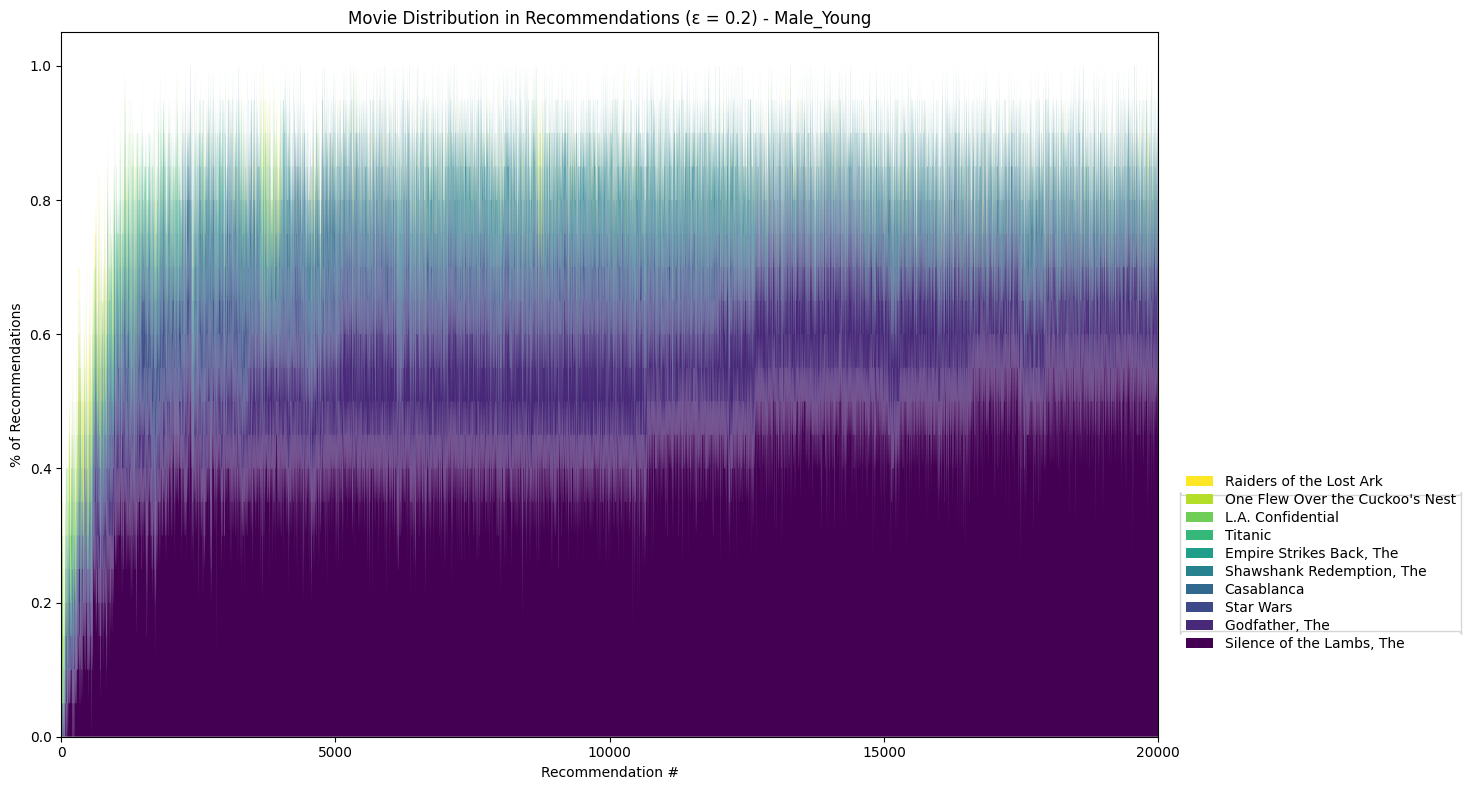


Analyzing Male_Adult

True Top 5 Most-Liked Movies:
1. Rear Window                                        (Like ratio: 90.9%, Count: 99.0)
2. To Kill a Mockingbird                              (Like ratio: 89.7%, Count: 87.0)
3. Schindler's List                                   (Like ratio: 89.6%, Count: 125.0)
4. One Flew Over the Cuckoo's Nest                    (Like ratio: 89.4%, Count: 123.0)
5. Shawshank Redemption, The                          (Like ratio: 88.9%, Count: 108.0)

Testing different epsilon values...


100%|██████████| 20/20 [00:07<00:00,  2.68it/s]



Best Configuration:
Epsilon: 0.1
Overlap with true top 5: 80.0%

Recommended Top 5 Movies:
105. To Kill a Mockingbird                              (Predicted reward: 0.899, Actual like ratio: 89.7%)
103. Rear Window                                        (Predicted reward: 0.899, Actual like ratio: 90.9%)
94. Shawshank Redemption, The                          (Predicted reward: 0.899, Actual like ratio: 88.9%)
95. One Flew Over the Cuckoo's Nest                    (Predicted reward: 0.897, Actual like ratio: 89.4%)
22. Fugitive, The                                      (Predicted reward: 0.885, Actual like ratio: 77.7%)


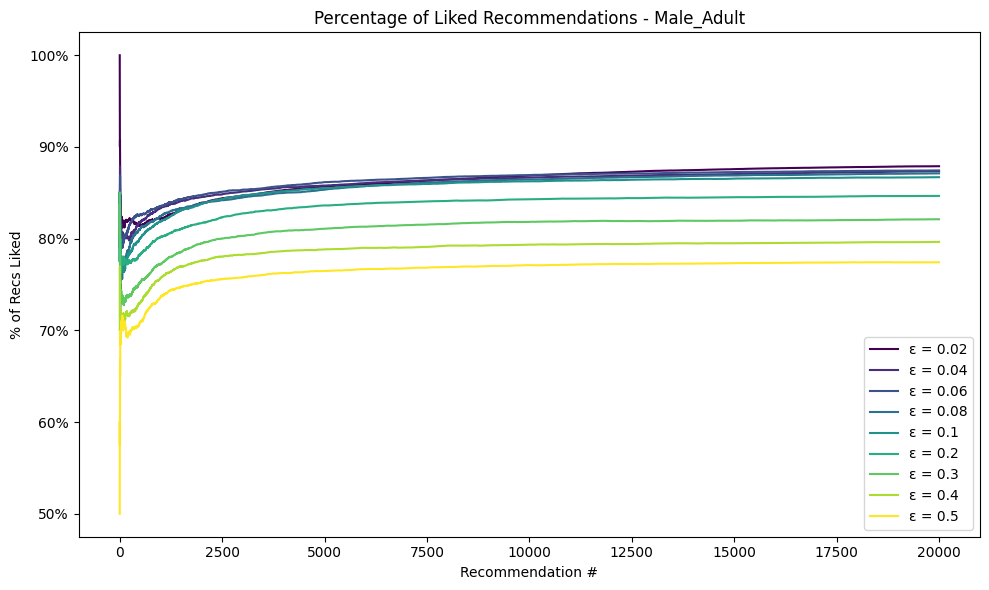

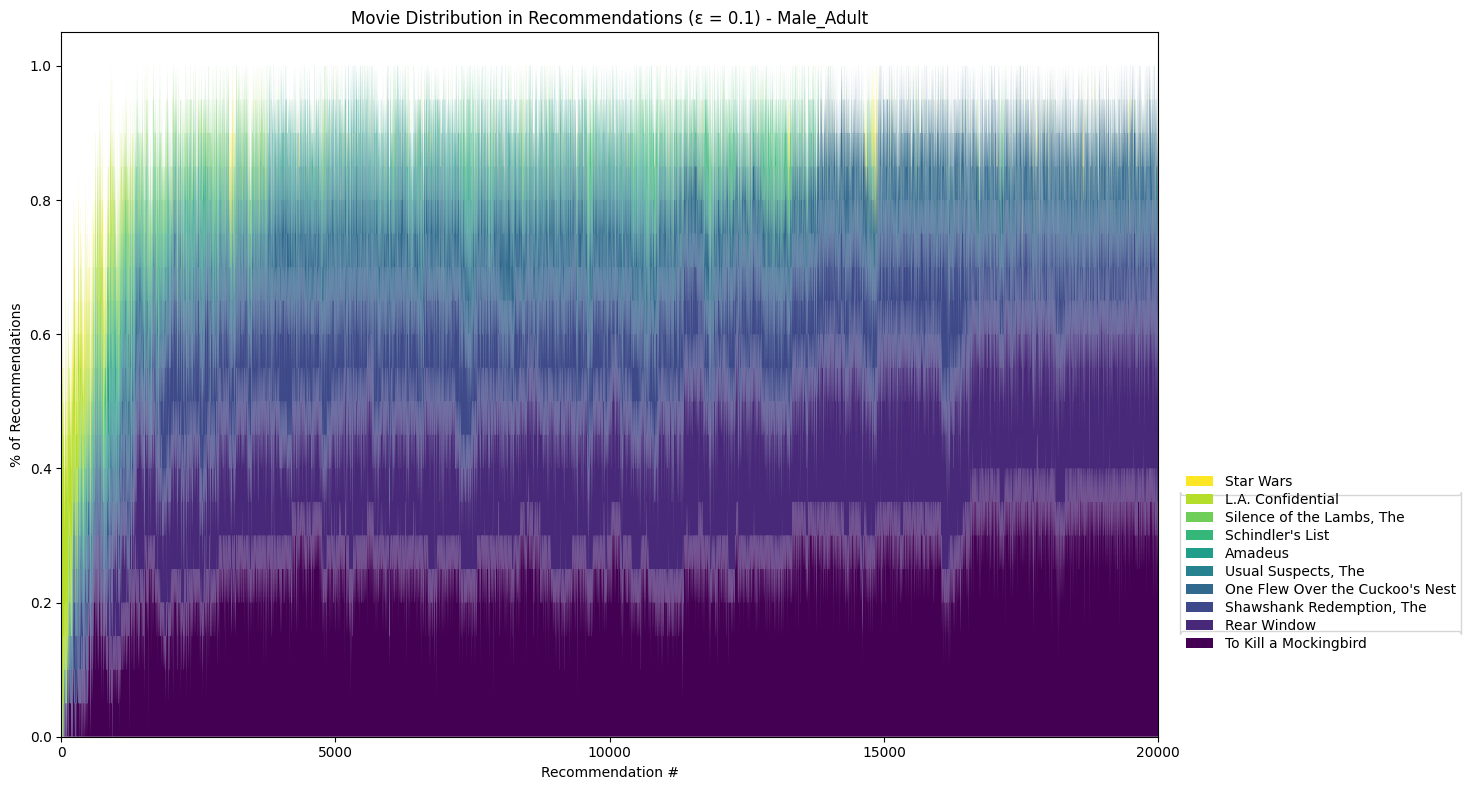


Analyzing Female_Young

True Top 5 Most-Liked Movies:
1. Shawshank Redemption, The                          (Like ratio: 96.7%, Count: 30.0)
2. Casablanca                                         (Like ratio: 95.2%, Count: 21.0)
3. Usual Suspects, The                                (Like ratio: 92.3%, Count: 26.0)
4. Schindler's List                                   (Like ratio: 92.1%, Count: 38.0)
5. Rear Window                                        (Like ratio: 88.9%, Count: 18.0)

Testing different epsilon values...


100%|██████████| 20/20 [00:08<00:00,  2.49it/s]



Best Configuration:
Epsilon: 0.06
Overlap with true top 5: 100.0%

Recommended Top 5 Movies:
69. Casablanca                                         (Predicted reward: 0.954, Actual like ratio: 95.2%)
77. Shawshank Redemption, The                          (Predicted reward: 0.952, Actual like ratio: 96.7%)
73. Schindler's List                                   (Predicted reward: 0.925, Actual like ratio: 92.1%)
34. Usual Suspects, The                                (Predicted reward: 0.917, Actual like ratio: 92.3%)
101. Rear Window                                        (Predicted reward: 0.915, Actual like ratio: 88.9%)


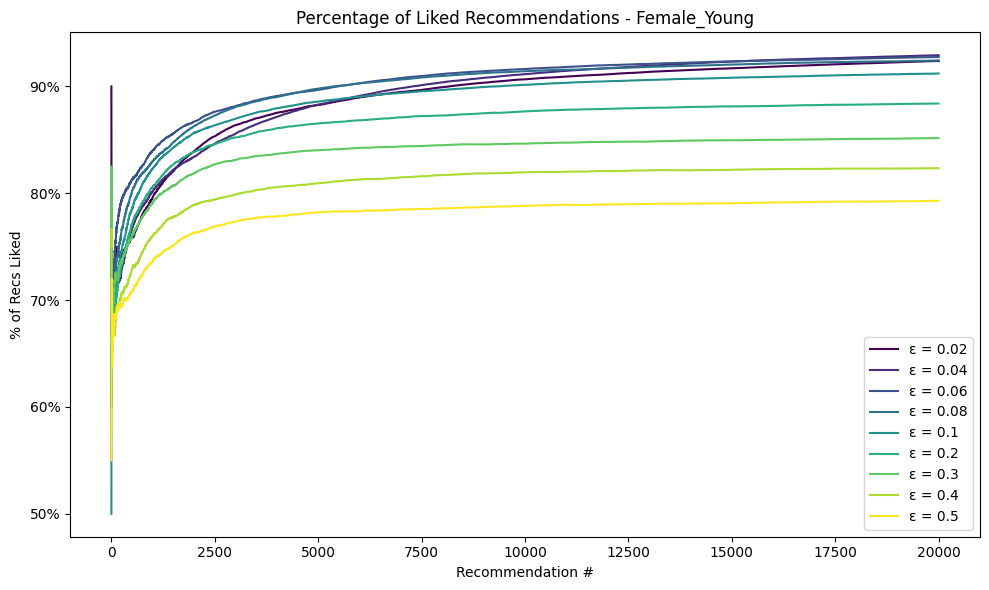

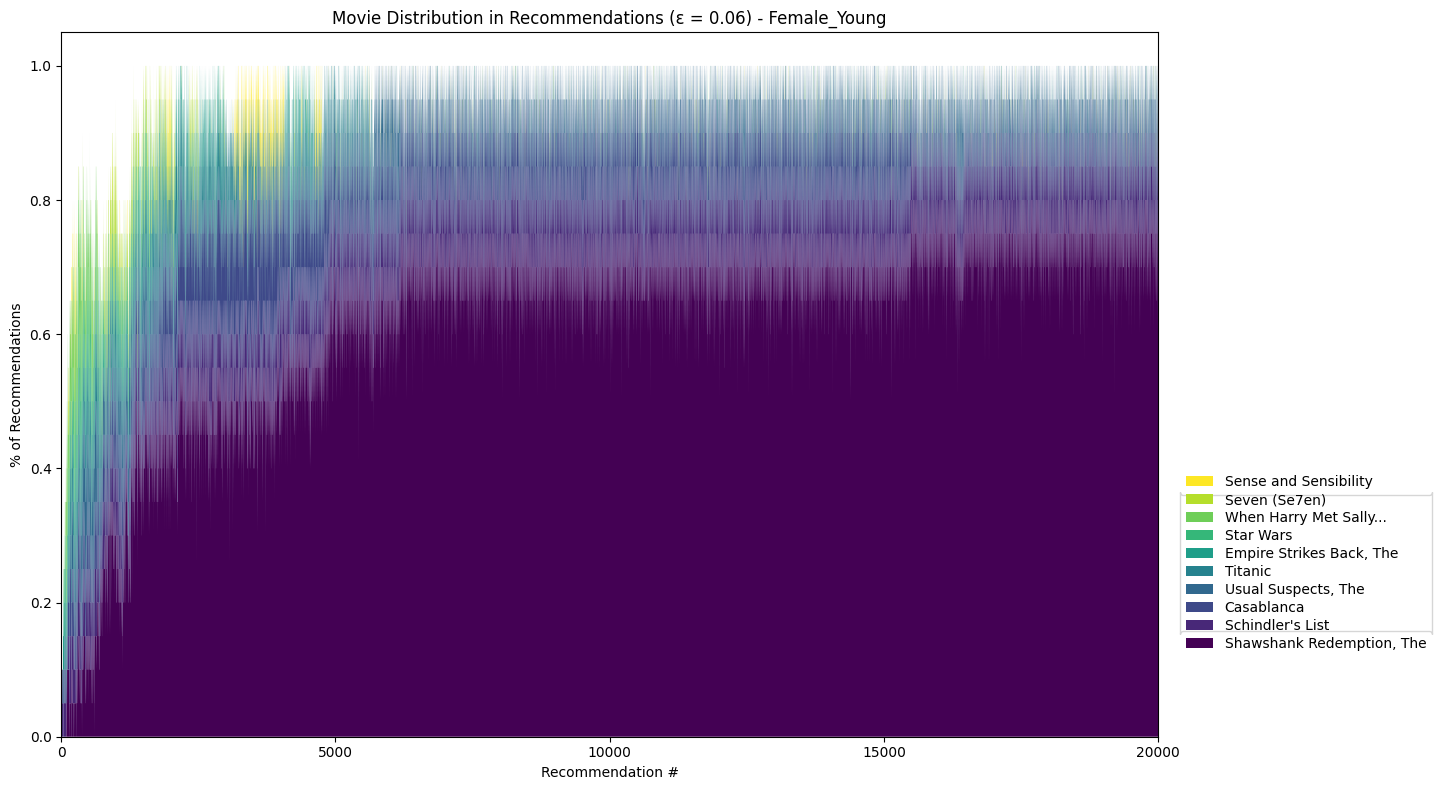


Analyzing Female_Adult

True Top 5 Most-Liked Movies:
1. Schindler's List                                   (Like ratio: 95.1%, Count: 41.0)
2. Fugitive, The                                      (Like ratio: 94.9%, Count: 39.0)
3. Boot, Das                                          (Like ratio: 93.1%, Count: 29.0)
4. Sense and Sensibility                              (Like ratio: 89.5%, Count: 57.0)
5. To Kill a Mockingbird                              (Like ratio: 88.4%, Count: 43.0)

Testing different epsilon values...


100%|██████████| 20/20 [00:08<00:00,  2.36it/s]



Best Configuration:
Epsilon: 0.2
Overlap with true top 5: 80.0%

Recommended Top 5 Movies:
51. Schindler's List                                   (Predicted reward: 0.950, Actual like ratio: 95.1%)
15. Fugitive, The                                      (Predicted reward: 0.949, Actual like ratio: 94.9%)
82. Boot, Das                                          (Predicted reward: 0.909, Actual like ratio: 93.1%)
7. Fargo                                              (Predicted reward: 0.909, Actual like ratio: 86.3%)
45. Sense and Sensibility                              (Predicted reward: 0.894, Actual like ratio: 89.5%)


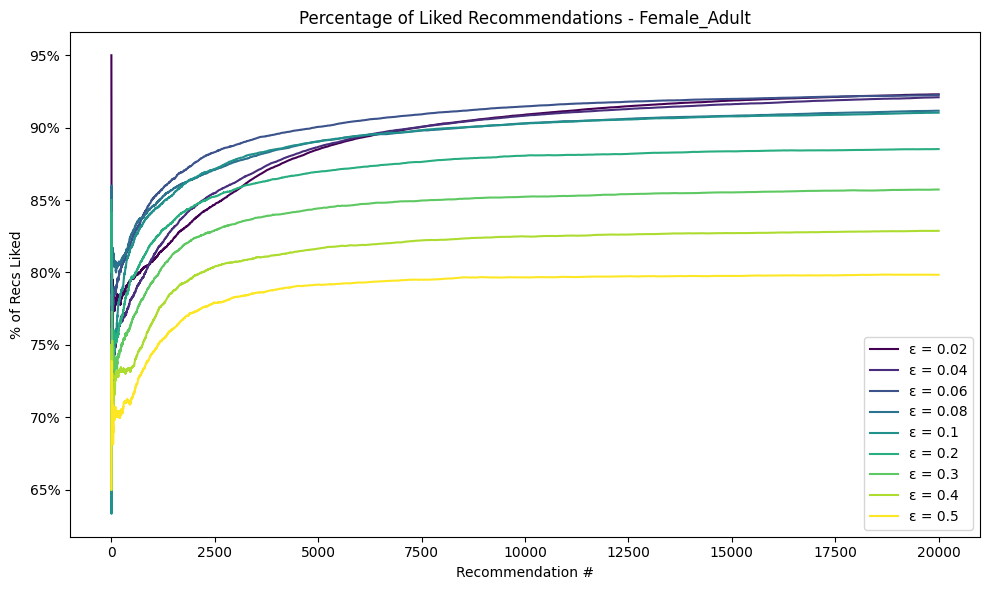

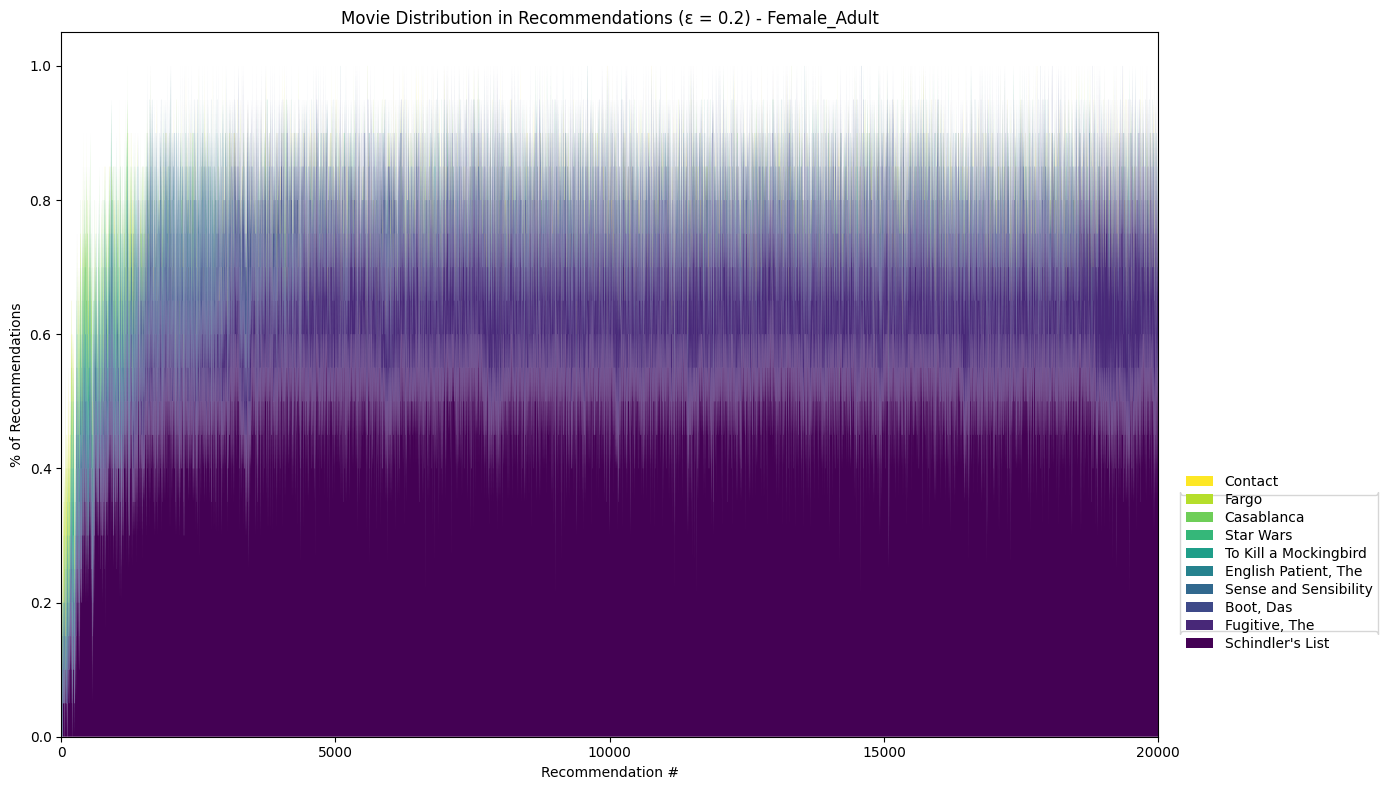

In [63]:
import warnings
warnings.filterwarnings('ignore')
print("=== Epsilon-Greedy MAB Analysis by Demographic Group ===\n")

for group_name, group_filter in demographic_groups.items():
    group_data = merged_df[group_filter]
    results[group_name] = analyze_and_plot_group(
        group_name, 
        group_data, 
        epsilon_values, 
        n_visits, 
        n_iterations
    )

In [64]:
print("Final Summary")
print("="*50)
for group_name, result in results.items():
    print(f"{group_name}:")
    print(f"Best epsilon: {result['best_epsilon']}")
    print(f"Overlap with true top 5: {result['best_overlap']:.1f}%")
    print("\nTrue Top 5 Movies:")
    for idx, (movie, stats) in enumerate(result['true_top_5'].iterrows(), 1):
        print(f"{idx}. {movie:<50} (Like ratio: {stats['mean']:.1%}, Count: {stats['count']})")
    print("\nRecommended Top 5 Movies:")
    for idx, row in result['recommended_top_5'].iterrows():
        print(f"{idx+1}. {row['movie']:<50} (Predicted reward: {row['reward']:.3f})")
    print("\n" + "="*50)

Final Summary
Male_Young:
Best epsilon: 0.2
Overlap with true top 5: 80.0%

True Top 5 Movies:
1. Silence of the Lambs, The                          (Like ratio: 92.8%, Count: 125.0)
2. Godfather, The                                     (Like ratio: 91.1%, Count: 124.0)
3. Shawshank Redemption, The                          (Like ratio: 91.0%, Count: 111.0)
4. Casablanca                                         (Like ratio: 90.9%, Count: 66.0)
5. Empire Strikes Back, The                           (Like ratio: 90.1%, Count: 142.0)

Recommended Top 5 Movies:
57. Casablanca                                         (Predicted reward: 0.910)
21. Godfather, The                                     (Predicted reward: 0.908)
35. Silence of the Lambs, The                          (Predicted reward: 0.906)
26. Star Wars                                          (Predicted reward: 0.903)
55. Empire Strikes Back, The                           (Predicted reward: 0.900)

Male_Adult:
Best epsilon: 0.1
Ove

## Thomas Sampling

In the previous section, it is noted that the epsilon values can have large impacts on the recommended videos. However, exploring multiple epsilon values can be deemed extremely inefficient. <br>
Therefore, there should be a more efficient method to balance the exploration and exploitation mechanisms in the multi-armed bandit algorithm. <br><br>
In this method, we aim to improve the algorithm by employing adaptive sampling via the Thomas sampling method which:
- Initialize prior beliefs at the beginning
- Select action and observe the rewards
- Update the probability distribution via Bayesian inference for the algorithm to balance between exploration and exploitation
- Repeat these steps until convergence

In [53]:
class ThompsonSamplingSimulator(ReplaySimulator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # initialize Beta distribution parameters
        self.alpha = np.ones(self.n_items)  # item successess
        self.beta = np.ones(self.n_items)   # item failures
    
    def select_item(self):
        # draw a sample from the Beta distribution for each item
        samples = np.random.beta(self.alpha, self.beta)
        # select item with highest sample
        return np.argmax(samples)
    
    def record_result(self, visit, item_idx, reward):
        # update Beta distribution parameters based on reward
        if reward == 1:
            self.alpha[item_idx] += 1
        else:
            self.beta[item_idx] += 1
        
        # update the original tracking metrics from parent class
        self.n_item_samples[item_idx] += 1
        alpha = 1. / self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])

In [57]:
def analyze_group_with_thompson(group_name, group_data, n_visits, n_iterations):
    print(f"\n{'='*50}\nAnalyzing {group_name} with Thompson Sampling\n{'='*50}")
    
    # get true top 5 movies
    true_top_movies = get_true_top_movies(group_data)
    print("\nTrue Top 5 Most-Liked Movies:")
    for idx, (movie, stats) in enumerate(true_top_movies.iterrows(), 1):
        print(f"{idx}. {movie:<50} (Like ratio: {stats['mean']:.1%}, Count: {stats['count']})")
    
    # run Thompson Sampling simulation
    simulator = ThompsonSamplingSimulator(
        n_visits=n_visits,
        reward_history=group_data,
        item_col_name='movie_title',
        visitor_col_name='user_id',
        reward_col_name='liked',
        n_iterations=n_iterations
    )
    
    results = simulator.replay()
    results_df = pd.DataFrame(results)
    
    # calculate expected rewards using Beta distribution parameters
    expected_rewards = simulator.alpha / (simulator.alpha + simulator.beta)
    
    # get final recommendations
    movie_performance = pd.DataFrame({
        'movie': simulator.items,
        'expected_reward': expected_rewards,
        'samples': simulator.n_item_samples,
        'alpha': simulator.alpha,
        'beta': simulator.beta
    }).sort_values('expected_reward', ascending=False)
    
    top_5_recommended = movie_performance.head()
    
    # calculate overlap
    overlap = len(set(top_5_recommended['movie']) & set(true_top_movies.index))
    overlap_percentage = (overlap / 5) * 100
    
    # print results
    print(f"\nOverlap with true top 5: {overlap_percentage:.1f}%")
    print("\nRecommended Top 5 Movies:")
    for idx, row in top_5_recommended.iterrows():
        movie = row['movie']
        likes_ratio = (group_data[group_data['movie_title'] == movie]['liked'] == 1).mean()
        print(f"{idx+1}. {movie:<50} "
              f"(Expected reward: {row['expected_reward']:.3f}, "
              f"Actual like ratio: {likes_ratio:.1%}, "
              f"Alpha: {row['alpha']:.1f}, "
              f"Beta: {row['beta']:.1f}, "
              f"Samples: {row['samples']})")
    
    # plot performance
    plt.figure(figsize=(10, 6))
    avg_results = results_df.groupby('visit')['fraction_relevant'].mean()
    plt.plot(avg_results.index, avg_results.values, 'b-', linewidth=1.5)
    plt.title(f'Performance Over Time - {group_name} (Thompson Sampling)')
    plt.xlabel('Recommendation #')
    plt.ylabel('% of Recs Liked')
    plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
    plt.tight_layout()
    plt.show()
    
    return {
        'overlap': overlap_percentage,
        'true_top_5': true_top_movies,
        'recommended_top_5': top_5_recommended,
        'results_df': results_df
    }

In [65]:
# initialize the parameters used
n_visits = 30000
n_iterations = 10
thompson_results = {}


Analyzing Male_Young with Thompson Sampling

True Top 5 Most-Liked Movies:
1. Silence of the Lambs, The                          (Like ratio: 92.8%, Count: 125.0)
2. Godfather, The                                     (Like ratio: 91.1%, Count: 124.0)
3. Shawshank Redemption, The                          (Like ratio: 91.0%, Count: 111.0)
4. Casablanca                                         (Like ratio: 90.9%, Count: 66.0)
5. Empire Strikes Back, The                           (Like ratio: 90.1%, Count: 142.0)


100%|██████████| 10/10 [00:20<00:00,  2.07s/it]



Overlap with true top 5: 100.0%

Recommended Top 5 Movies:
35. Silence of the Lambs, The                          (Expected reward: 0.928, Actual like ratio: 92.8%, Alpha: 260749.0, Beta: 20209.0, Samples: 29794.0)
21. Godfather, The                                     (Expected reward: 0.916, Actual like ratio: 91.1%, Alpha: 4243.0, Beta: 387.0, Samples: 43.0)
57. Casablanca                                         (Expected reward: 0.915, Actual like ratio: 90.9%, Alpha: 3355.0, Beta: 310.0, Samples: 48.0)
68. Shawshank Redemption, The                          (Expected reward: 0.908, Actual like ratio: 91.0%, Alpha: 2004.0, Beta: 202.0, Samples: 11.0)
55. Empire Strikes Back, The                           (Expected reward: 0.906, Actual like ratio: 90.1%, Alpha: 1639.0, Beta: 170.0, Samples: 10.0)


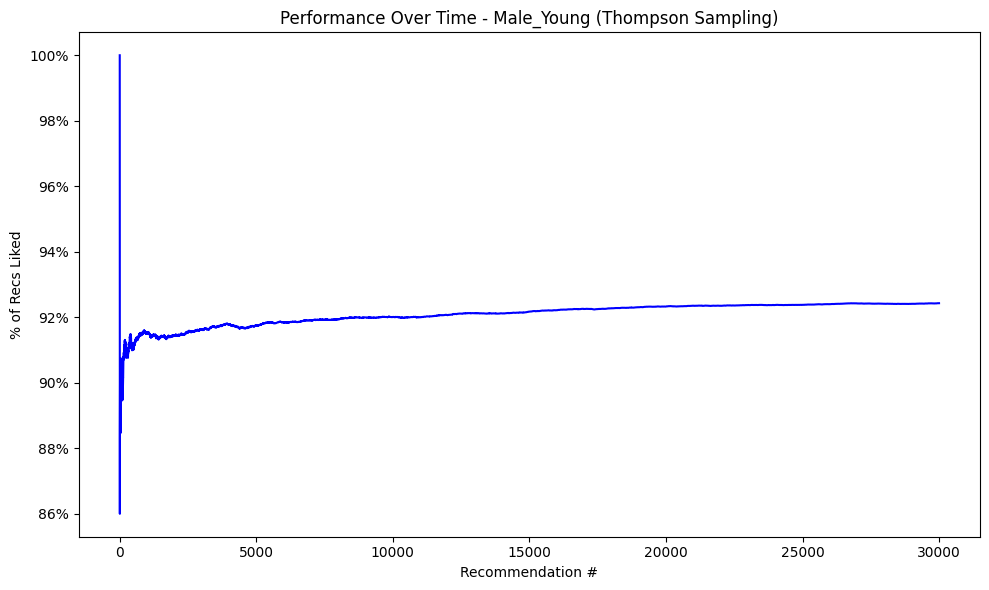


Analyzing Male_Adult with Thompson Sampling

True Top 5 Most-Liked Movies:
1. Rear Window                                        (Like ratio: 90.9%, Count: 99.0)
2. To Kill a Mockingbird                              (Like ratio: 89.7%, Count: 87.0)
3. Schindler's List                                   (Like ratio: 89.6%, Count: 125.0)
4. One Flew Over the Cuckoo's Nest                    (Like ratio: 89.4%, Count: 123.0)
5. Shawshank Redemption, The                          (Like ratio: 88.9%, Count: 108.0)


100%|██████████| 10/10 [00:32<00:00,  3.29s/it]



Overlap with true top 5: 100.0%

Recommended Top 5 Movies:
103. Rear Window                                        (Expected reward: 0.908, Actual like ratio: 90.9%, Alpha: 236079.0, Beta: 23863.0, Samples: 29764.0)
93. Schindler's List                                   (Expected reward: 0.901, Actual like ratio: 89.6%, Alpha: 12910.0, Beta: 1421.0, Samples: 104.0)
94. Shawshank Redemption, The                          (Expected reward: 0.895, Actual like ratio: 88.9%, Alpha: 5041.0, Beta: 594.0, Samples: 13.0)
95. One Flew Over the Cuckoo's Nest                    (Expected reward: 0.893, Actual like ratio: 89.4%, Alpha: 4762.0, Beta: 570.0, Samples: 4.0)
105. To Kill a Mockingbird                              (Expected reward: 0.893, Actual like ratio: 89.7%, Alpha: 3765.0, Beta: 452.0, Samples: 11.0)


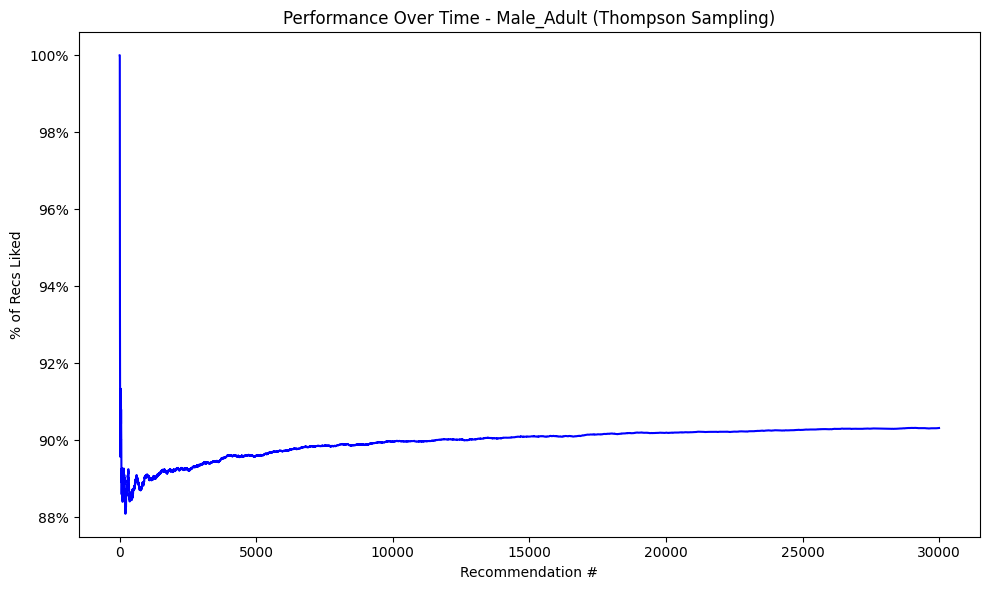


Analyzing Female_Young with Thompson Sampling

True Top 5 Most-Liked Movies:
1. Shawshank Redemption, The                          (Like ratio: 96.7%, Count: 30.0)
2. Casablanca                                         (Like ratio: 95.2%, Count: 21.0)
3. Usual Suspects, The                                (Like ratio: 92.3%, Count: 26.0)
4. Schindler's List                                   (Like ratio: 92.1%, Count: 38.0)
5. Rear Window                                        (Like ratio: 88.9%, Count: 18.0)


100%|██████████| 10/10 [00:33<00:00,  3.34s/it]



Overlap with true top 5: 60.0%

Recommended Top 5 Movies:
77. Shawshank Redemption, The                          (Expected reward: 0.967, Actual like ratio: 96.7%, Alpha: 286224.0, Beta: 9912.0, Samples: 29983.0)
69. Casablanca                                         (Expected reward: 0.939, Actual like ratio: 95.2%, Alpha: 616.0, Beta: 40.0, Samples: 6.0)
73. Schindler's List                                   (Expected reward: 0.936, Actual like ratio: 92.1%, Alpha: 673.0, Beta: 46.0, Samples: 1.0)
102. To Kill a Mockingbird                              (Expected reward: 0.886, Actual like ratio: 88.5%, Alpha: 117.0, Beta: 15.0, Samples: 0.0)
78. One Flew Over the Cuckoo's Nest                    (Expected reward: 0.875, Actual like ratio: 87.0%, Alpha: 105.0, Beta: 15.0, Samples: 0.0)


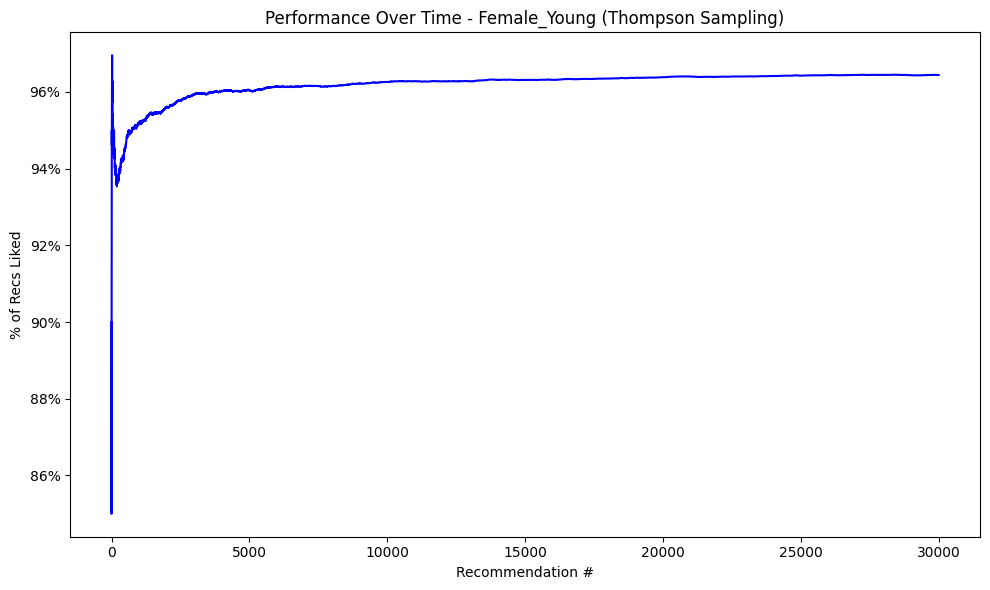


Analyzing Female_Adult with Thompson Sampling

True Top 5 Most-Liked Movies:
1. Schindler's List                                   (Like ratio: 95.1%, Count: 41.0)
2. Fugitive, The                                      (Like ratio: 94.9%, Count: 39.0)
3. Boot, Das                                          (Like ratio: 93.1%, Count: 29.0)
4. Sense and Sensibility                              (Like ratio: 89.5%, Count: 57.0)
5. To Kill a Mockingbird                              (Like ratio: 88.4%, Count: 43.0)


100%|██████████| 10/10 [00:32<00:00,  3.29s/it]



Overlap with true top 5: 80.0%

Recommended Top 5 Movies:
51. Schindler's List                                   (Expected reward: 0.950, Actual like ratio: 95.1%, Alpha: 244465.0, Beta: 12763.0, Samples: 29737.0)
15. Fugitive, The                                      (Expected reward: 0.947, Actual like ratio: 94.9%, Alpha: 36258.0, Beta: 2017.0, Samples: 162.0)
82. Boot, Das                                          (Expected reward: 0.928, Actual like ratio: 93.1%, Alpha: 747.0, Beta: 58.0, Samples: 67.0)
45. Sense and Sensibility                              (Expected reward: 0.909, Actual like ratio: 89.5%, Alpha: 408.0, Beta: 41.0, Samples: 6.0)
63. Rear Window                                        (Expected reward: 0.893, Actual like ratio: 86.1%, Alpha: 234.0, Beta: 28.0, Samples: 5.0)


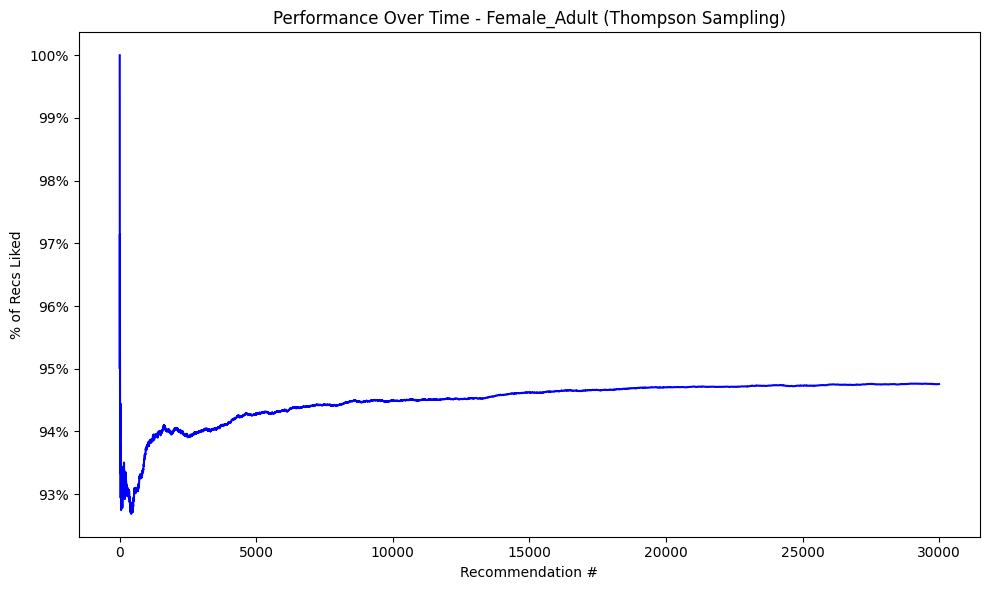

In [66]:
for group_name, group_filter in demographic_groups.items():
    group_data = merged_df[group_filter]
    thompson_results[group_name] = analyze_group_with_thompson(
        group_name, 
        group_data, 
        n_visits, 
        n_iterations
    )